In [100]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,confusion_matrix
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

In [2]:
# reading raw data
raw_data = pd.read_csv("./BOM.csv")
raw_data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145455,2017-06-21,Uluru,2.8,23.4,0.0,NaN,NaN,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,NaN,NaN,10.1,22.4,No,No
145456,2017-06-22,Uluru,3.6,25.3,0.0,NaN,NaN,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,NaN,NaN,10.9,24.5,No,No
145457,2017-06-23,Uluru,5.4,26.9,0.0,NaN,NaN,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,NaN,NaN,12.5,26.1,No,No
145458,2017-06-24,Uluru,7.8,27.0,0.0,NaN,NaN,SE,28.0,SSE,...,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No


In [3]:
# deleting data that has not target value
data = raw_data.dropna(subset = ["RainTomorrow"])

In [4]:
def ChangeDate(x):
    tmp = x["Date"]
    tmp = list(tmp.split("-"))
    tmp = int(tmp[0]+tmp[1])
    x["Date"] = tmp
    return x 

# Change date format to use it as feature for filtering when computting median or mode to fill nan
data = data.apply(lambda x: ChangeDate(x), axis=1)


In [5]:
def FillNa(item,data_=None,cols=None):
    tmp = data_.loc[data_['Date'] == item["Date"]]
    for col in cols:
        if not(pd.isna(item[col])):
                continue
        else :
            try:
                item[col] = round(tmp[col].median(),2)
            except:
                item[col] = tmp[col].mode()[0]
    return item

cols = ["MinTemp","MaxTemp","Rainfall","Evaporation","Sunshine","WindGustDir","WindGustSpeed","WindDir9am","WindDir3pm","WindSpeed9am","WindSpeed3pm","Humidity9am","Humidity3pm","Pressure9am","Pressure3pm","Cloud9am","Cloud3pm","Temp9am","Temp3pm","RainToday"]

# fill nan
data = data.apply(lambda x: FillNa(x,data,cols), axis=1)

In [6]:
data

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,200812,Albury,13.4,22.9,0.6,6.8,9.40,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,5.0,16.9,21.8,No,No
1,200812,Albury,7.4,25.1,0.0,6.8,9.40,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,6.0,5.0,17.2,24.3,No,No
2,200812,Albury,12.9,25.7,0.0,6.8,9.40,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,6.0,2.0,21.0,23.2,No,No
3,200812,Albury,9.2,28.0,0.0,6.8,9.40,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,6.0,5.0,18.1,26.5,No,No
4,200812,Albury,17.5,32.3,1.0,6.8,9.40,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,201706,Uluru,3.5,21.8,0.0,2.2,7.35,E,31.0,ESE,...,59.0,27.0,1024.7,1021.2,6.0,6.0,9.4,20.9,No,No
145455,201706,Uluru,2.8,23.4,0.0,2.2,7.35,E,31.0,SE,...,51.0,24.0,1024.6,1020.3,6.0,6.0,10.1,22.4,No,No
145456,201706,Uluru,3.6,25.3,0.0,2.2,7.35,NNW,22.0,SE,...,56.0,21.0,1023.5,1019.1,6.0,6.0,10.9,24.5,No,No
145457,201706,Uluru,5.4,26.9,0.0,2.2,7.35,N,37.0,SE,...,53.0,24.0,1021.0,1016.8,6.0,6.0,12.5,26.1,No,No


In [19]:
# ------------------------------------------------------ A ------------------------------------------------------#
print(data.shape)
# calculating Correlation Coefficient matrix 
correlation_coefficients = np.array(data.corr())

# printing fields that have Correlation Coefficient greater than 0.95
to_remove = []
for i in range(len(correlation_coefficients)):
    for j in range(i):
        if correlation_coefficients[i][j] >0.95 and i!=j:
            print("Correlation Coefficient between {0} and {1} is {2}".format(cols[i+2],cols[j+2],correlation_coefficients[i][j]))
            to_remove.append(cols[i+2])
data.drop(columns=to_remove,inplace=True)
print(data.shape)
data

(142193, 23)
Correlation Coefficient between Pressure3pm and Pressure9am is 0.9611560115076907
Correlation Coefficient between Temp3pm and Sunshine is 0.971630229128176
(142193, 21)


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Cloud9am,Cloud3pm,Temp9am,RainToday,RainTomorrow
0,200812,Albury,13.4,22.9,0.6,6.8,9.40,W,44.0,W,...,20.0,24.0,71.0,22.0,1007.7,8.0,5.0,16.9,No,No
1,200812,Albury,7.4,25.1,0.0,6.8,9.40,WNW,44.0,NNW,...,4.0,22.0,44.0,25.0,1010.6,6.0,5.0,17.2,No,No
2,200812,Albury,12.9,25.7,0.0,6.8,9.40,WSW,46.0,W,...,19.0,26.0,38.0,30.0,1007.6,6.0,2.0,21.0,No,No
3,200812,Albury,9.2,28.0,0.0,6.8,9.40,NE,24.0,SE,...,11.0,9.0,45.0,16.0,1017.6,6.0,5.0,18.1,No,No
4,200812,Albury,17.5,32.3,1.0,6.8,9.40,W,41.0,ENE,...,7.0,20.0,82.0,33.0,1010.8,7.0,8.0,17.8,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145454,201706,Uluru,3.5,21.8,0.0,2.2,7.35,E,31.0,ESE,...,15.0,13.0,59.0,27.0,1024.7,6.0,6.0,9.4,No,No
145455,201706,Uluru,2.8,23.4,0.0,2.2,7.35,E,31.0,SE,...,13.0,11.0,51.0,24.0,1024.6,6.0,6.0,10.1,No,No
145456,201706,Uluru,3.6,25.3,0.0,2.2,7.35,NNW,22.0,SE,...,13.0,9.0,56.0,21.0,1023.5,6.0,6.0,10.9,No,No
145457,201706,Uluru,5.4,26.9,0.0,2.2,7.35,N,37.0,SE,...,9.0,9.0,53.0,24.0,1021.0,6.0,6.0,12.5,No,No


In [53]:
#convert string data to numerical with categorical encoding
data = data.sample(frac=1).reset_index(drop=True)
for col in cols:
    try:
        if type(data[col][0]) is str:
            data[col] = data[col].astype('category').cat.codes
    except:
        continue
        
Y_total = data["RainTomorrow"]
X_total = data.drop(columns=["RainTomorrow","Date","Location"])

In [67]:
# ------------------------------------------------------ B ------------------------------------------------------#
#use Decision Tree Classifier as the objective function
estimator = DecisionTreeClassifier(criterion="entropy")

#remove each feature in one step 
selector = RFE(estimator, 10, step=1)
selector = selector.fit(X_total, Y_total)
selector.ranking_


array([1, 1, 3, 1, 1, 6, 1, 5, 1, 2, 4, 1, 1, 1, 8, 7, 1, 9])

In [73]:
# remove the addintional features 
to_remove = []
for col in range(len(X_total.columns)):
    if selector.ranking_[col] == 1:
        continue
    to_remove.append(X_total.columns[col])
    
print("to remove: ", to_remove)
X_total = X_total.drop(columns=to_remove)
X_total

to remove:  ['Rainfall', 'WindGustDir', 'WindDir9am', 'WindSpeed9am', 'WindSpeed3pm', 'Cloud9am', 'Cloud3pm', 'RainToday']


,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindDir3pm,Humidity9am,Humidity3pm,Pressure9am,Temp9am
0,18.3,30.7,7.8,11.1,31.0,4,60.0,57.0,1015.8,22.7
1,14.5,25.6,3.8,6.6,52.0,0,67.0,39.0,1018.1,18.9
2,14.2,36.3,10.2,11.6,33.0,15,26.0,17.0,1012.1,27.5
3,20.2,28.9,5.8,8.7,43.0,4,71.0,72.0,1016.7,24.8
4,5.8,15.7,2.4,5.3,35.0,3,85.0,62.0,1022.3,8.9
...,...,...,...,...,...,...,...,...,...,...
142188,5.8,21.1,2.4,10.3,35.0,4,97.0,43.0,1027.5,9.1
142189,22.6,36.7,11.6,11.3,50.0,3,60.0,29.0,1013.7,26.3
142190,4.7,9.3,2.2,6.9,37.0,12,79.0,75.0,1019.0,5.9
142191,11.4,20.1,2.4,9.6,41.0,7,74.0,44.0,1013.5,14.5


In [91]:
# ------------------------------------------------------ C ------------------------------------------------------#
# use 30% of dataset for test
X_train, X_test, Y_train, Y_test = train_test_split(X_total, Y_total, test_size=0.3)

# use k-fold to validation, so i use 5-fold which means that function calculate 20% of traing data to validate each step itself
knn = KNeighborsClassifier()
param_grid = {"n_neighbors": np.arange(1, 20)}

#grid search to find best k of nearest neighbors with 5-fold(20% of traing data ~ 15 of total data)
knn_gscv = GridSearchCV(knn, param_grid, cv=5,verbose=4)
knn_gscv.fit(X_train, Y_train)

knn_gscv.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ....................... n_neighbors=1, score=0.789, total=   3.6s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.784, total=   3.7s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.2s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.783, total=   3.7s
[CV] n_neighbors=1 ...................................................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s


[CV] ....................... n_neighbors=1, score=0.785, total=   3.8s
[CV] n_neighbors=1 ...................................................
[CV] ....................... n_neighbors=1, score=0.790, total=   3.1s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.818, total=   4.2s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.818, total=   4.0s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.817, total=   4.3s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.820, total=   4.2s
[CV] n_neighbors=2 ...................................................
[CV] ....................... n_neighbors=2, score=0.820, total=   3.8s
[CV] n_neighbors=3 ...................................................
[CV] .

[CV] ...................... n_neighbors=13, score=0.837, total=   7.3s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.840, total=   6.6s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.840, total=   6.8s
[CV] n_neighbors=13 ..................................................
[CV] ...................... n_neighbors=13, score=0.840, total=   5.5s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.840, total=   6.7s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.837, total=   6.4s
[CV] n_neighbors=14 ..................................................
[CV] ...................... n_neighbors=14, score=0.839, total=   6.6s
[CV] n_neighbors=14 ..................................................
[CV] .

[Parallel(n_jobs=1)]: Done  95 out of  95 | elapsed:  9.8min finished


{'n_neighbors': 17}

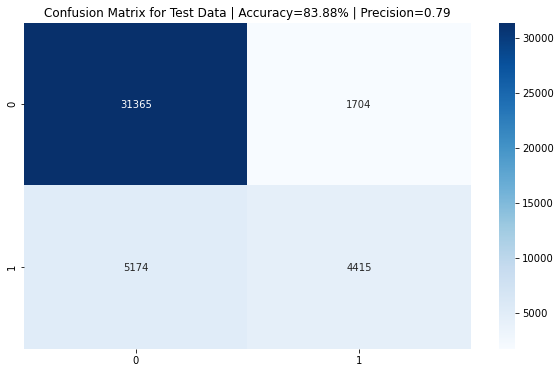

In [107]:
def CalculateMetricsAndPlot(true_label, predicted_label,color="Blues"):
    #calculate metrics
    CM = confusion_matrix(true_label, predicted_label)
    acc = round(accuracy_score(true_label,predicted_label)*100,2)
    precision = round(precision_score(true_label,predicted_label, average='macro'),2)
    
    #plot confusion matrix with accuracy and precision
    sns.heatmap(CM ,annot=True, cmap=color, fmt='g').set_title("Confusion Matrix for Test Data | Accuracy={0}% | Precision={1}".format(acc,precision))
    plt.show()
 
# Create classifier with besk calculated K=17
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_["n_neighbors"])
knn.fit(X_train, Y_train)

#testing model with testset
y_pred = knn.predict(X_test)

#plot result
CalculateMetricsAndPlot(Y_test,y_pred)

In [109]:
# ------------------------------------------------------ D ------------------------------------------------------#
rasht = [1,9,2.6,5.9,31,0,100,97,1015,7] # extracted manually | please read report 
knn.predict([rasht])
#  Tomorrow will be rain (2022-1-21) based on our prediction

array(['Yes'], dtype=object)

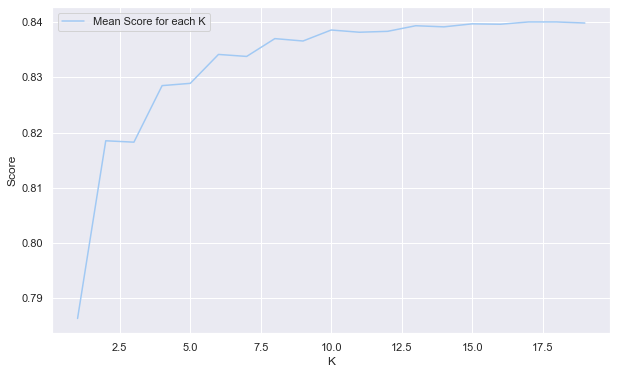

In [122]:
# ---------------------------------------------------- Chart for C ----------------------------------------------------#
sns.set_theme(style="darkgrid", palette="pastel")
plt.plot( np.arange(1, 20),knn_gscv.cv_results_["mean_test_score"],label="Mean Score for each K")
plt.xlabel("K")
plt.ylabel("Score")
plt.legend()
plt.show()